# Bayesian Regression with numpyro

- Does not work in Windows 10
- Derived from pyro. So most of the interface should be learnt from `pyro`
- Good numpyro tutorial for Bayesian modeling.

See `num.pyro.ai`
```
$ pip install numpyro jax jaxlib
```

In [1]:
import sys
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

In [2]:
import numpy as np
from jax import numpy as jnp, random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpyro as npr
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
numpyro.set_host_device_count(4)

In [3]:
%load_ext watermark
%watermark -p numpyro,jax,arviz,numpy,pandas,seaborn

numpyro: 0.5.0
jax    : 0.2.8
arviz  : 0.11.0
numpy  : 1.19.5
pandas : 1.2.1
seaborn: 0.11.1



## Data
The following example is adapted from [1]. We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable rugged in the dataset) and its GDP per capita. In particular, it was noted by the authors in [2] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship. We will be focusing on three features from the dataset: 
- cont_africa: whether the given nation is in Africa 
- rugged: quantifies the Terrain Ruggedness Index 
- rgdppc_2000: Real GDP per capita for the year 2000

**References**
1. McElreath, D., Statistical Rethinking, Chapter 7, 2016
2. Nunn, N. & Puga, D., Ruggedness: The blessing of bad geography in Africa”, Review of Economics and Statistics 94(1), Feb. 2012

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df.dropna()
df["rgdppc_2000"] = df["rgdppc_2000"].map(np.log)

In [5]:
df.tail(4)

,cont_africa,rugged,rgdppc_2000
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585
233,1,1.194,7.823732


## Visual Exploration

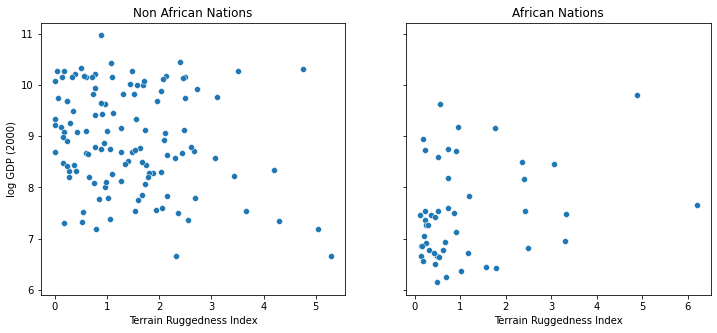

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Linear Regression (MLE)

In [7]:
from sklearn.linear_model import LinearRegression
# 1. create linear regression object
regr = LinearRegression()
# 2. fit the model using the data sets
regr.fit(african_nations['rugged'].values[:, np.newaxis], african_nations['rgdppc_2000'].values[:,np.newaxis])
# 3. see the coefficients
print('Linear regression: ', regr.coef_, regr.intercept_)

Linear regression:  [[0.19053672]] [7.27517836]


In [8]:
x = np.linspace(start=african_nations['rugged'].min(), stop=african_nations['rugged'].max(), num=10)
y = regr.predict(x[:,np.newaxis])
y.shape

(10, 1)

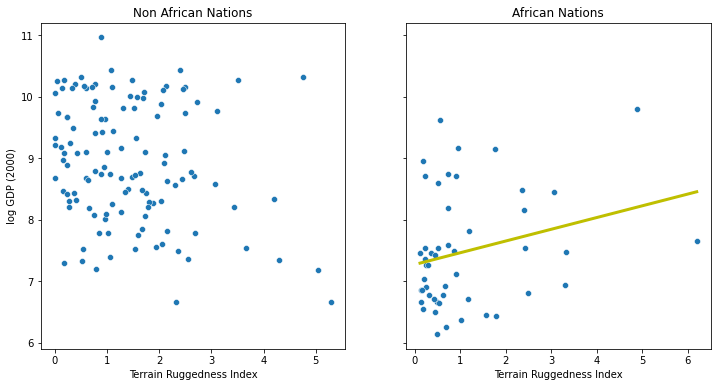

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");
# now plot the regression line
ax[1].plot(x, y, c='y', lw=3);

**E.1** plot the regression line for Non-Arican Nations.

## Full Bayesian Regression

- Apply MCMC technique to obtain random samples from the posterior distrubtion
- The data should be 'JAX numpy' for speed up
    - fortunately user interface between the two is 99.9% the same.

In [10]:
data_tt = jnp.array(df.values)  # JAX array
print(data_tt[:2])

# separate data_tt into three arrays with names
is_cont_africa, ruggedness, log_gdp = data_tt[:, 0], data_tt[:, 1], data_tt[:, 2]

[[1.        0.858     7.4926095]
 [0.        3.427     8.216929 ]]


In [11]:
# describe your own generative model
def mu_func(is_cont_africa, ruggedness, a, b_a, b_r, b_ar):
    return a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

def model(is_cont_africa, ruggedness, log_gdp=None):
    a = numpyro.sample("a", dist.Normal(0., 10.))
    b_a = numpyro.sample("bA", dist.Normal(0., 1.))
    b_r = numpyro.sample("bR", dist.Normal(0., 1.))
    b_ar = numpyro.sample("bAR", dist.Normal(0., 1.))
    sigma = numpyro.sample("sigma", dist.Uniform(0., 10.))
    mean = mu_func(is_cont_africa, ruggedness, a, b_a, b_r, b_ar)
    mu = numpyro.deterministic('mu', mean)  # for convenience later
    
    with numpyro.plate("data", len(ruggedness)):
        obs = numpyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    return obs
#

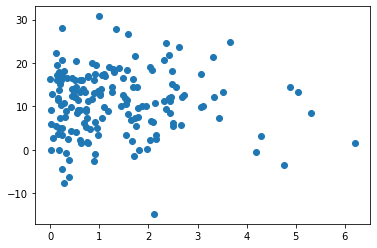

In [21]:
# prior predictive distribution (without observation)
with numpyro.handlers.seed(rng_seed=random.PRNGKey(101)):
    obs_prior = model(is_cont_africa, ruggedness)  # the output will change every time
plt.scatter(ruggedness, obs_prior);

In [13]:
with numpyro.handlers.seed(rng_seed=random.PRNGKey(1)):
    mcmc = MCMC(NUTS(model), num_warmup=200, num_samples=2000, num_chains=4)
    mcmc.run(random.PRNGKey(0), is_cont_africa, ruggedness, log_gdp)

In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      9.18      0.14      9.18      8.96      9.41   3156.74      1.00
        bA     -1.84      0.22     -1.84     -2.20     -1.47   3101.22      1.00
       bAR      0.34      0.13      0.34      0.13      0.56   3383.78      1.00
        bR     -0.18      0.08     -0.18     -0.31     -0.06   3079.05      1.00
     sigma      0.95      0.05      0.95      0.86      1.04   6911.66      1.00

Number of divergences: 0


In [16]:
hmc_samples = mcmc.get_samples()
hmc_samples

{'a': DeviceArray([8.791116, 9.059187, 8.854503, ..., 9.129156, 9.227676,
              9.143748], dtype=float32),
 'bA': DeviceArray([-1.6179718, -1.6217371, -1.7962604, ..., -1.7299914,
              -1.7735846, -1.8727053], dtype=float32),
 'bAR': DeviceArray([0.2878306 , 0.23967692, 0.2697419 , ..., 0.3078114 ,
              0.25803703, 0.3012811 ], dtype=float32),
 'bR': DeviceArray([ 0.00405189, -0.04423419, -0.0777836 , ..., -0.11909996,
              -0.13259928, -0.17027792], dtype=float32),
 'mu': DeviceArray([[7.423579 , 8.805001 , 8.794231 , ..., 7.687149 , 7.328717 ,
               7.5216517],
              [7.6051397, 8.907597 , 9.025171 , ..., 7.7816243, 7.541621 ,
               7.670809 ],
              [7.222943 , 8.587938 , 8.794687 , ..., 7.3962812, 7.1605563,
               7.287441 ],
              ...,
              [7.561079 , 8.721001 , 9.037568 , ..., 7.731486 , 7.4997478,
               7.6244864],
              [7.561718 , 8.773258 , 9.125708 , ..., 7.674988

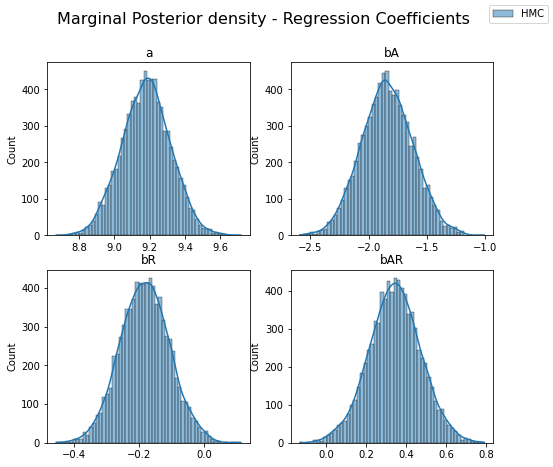

In [17]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(hmc_samples[site], ax=ax, label="HMC", kde=True)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

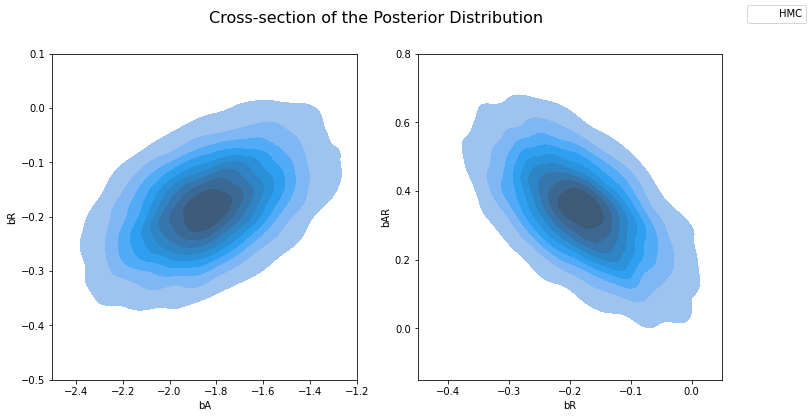

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### Posterior Predictive Check

In [44]:
predictive = Predictive(model, posterior_samples=hmc_samples) #

# predictions will be made for this values
rgdns = jnp.linspace(0, ruggedness.max()*1.01, 51) #[0, 1, 2, 3, 4, 5, 6])
ica =   jnp.array([1]*len(rgdns))

# make posterior prediction
ppsamples = predictive(random.PRNGKey(0), is_cont_africa=ica, ruggedness=rgdns)
pps_obs = ppsamples['obs']; pps_obs.shape, type(ppsamples)

((8000, 51), dict)

In [45]:
ppsamples.keys(), ppsamples['mu'].shape

(dict_keys(['mu', 'obs']), (8000, 51))

In [46]:
# posterior HDI with obs noise
hdi_obs = arviz.hdi(np.array(pps_obs), hdi_prob=.9)  

# posterior HDI without obs noise
hdi = arviz.hdi(np.array(ppsamples['mu']), hdi_prob=.9)

/home/yndk/.local/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


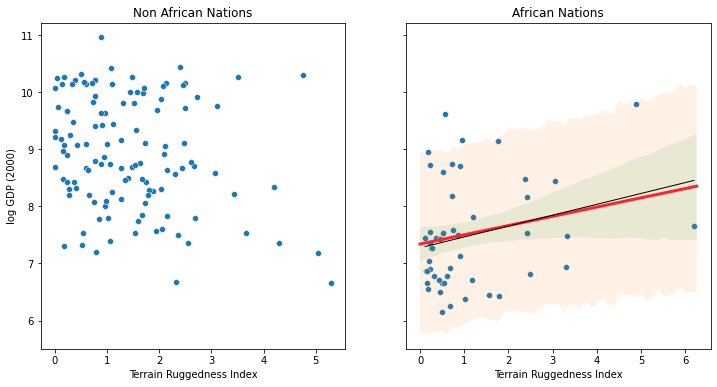

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");
# now plot the MMCM regression lines and the posterior mean line
mean_sites = [hmc_samples[s].mean() for s in sites]
mean_y = mu_func(1, rgdns, *mean_sites[:-1])
ax[1].plot(rgdns, mean_y, c='#ff2233', lw=3);  # regression line with posterior mean parameters
ax[1].plot(x, y, c='k', lw=1);  # MLE line
ax[1].fill_between(rgdns, hdi_obs[:,0], hdi_obs[:,1], alpha=.1)  # posterior predictive observation with sigma
ax[1].fill_between(rgdns, hdi[:, 0], hdi[:,1], alpha=.1)  # pp observation w/o sigma

In [49]:
# visualization of the result is convenient with `arviz`
import arviz

inferenceData = arviz.from_numpyro(mcmc)

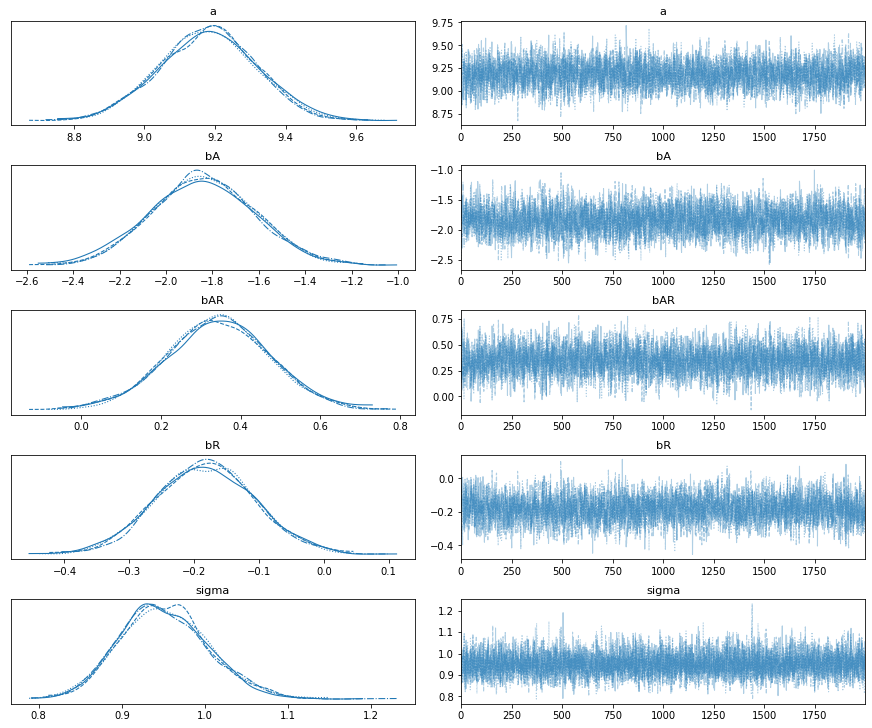

In [50]:
arviz.plot_trace(inferenceData, var_names=['a', 'bA', 'bAR', 'bR', 'sigma']);

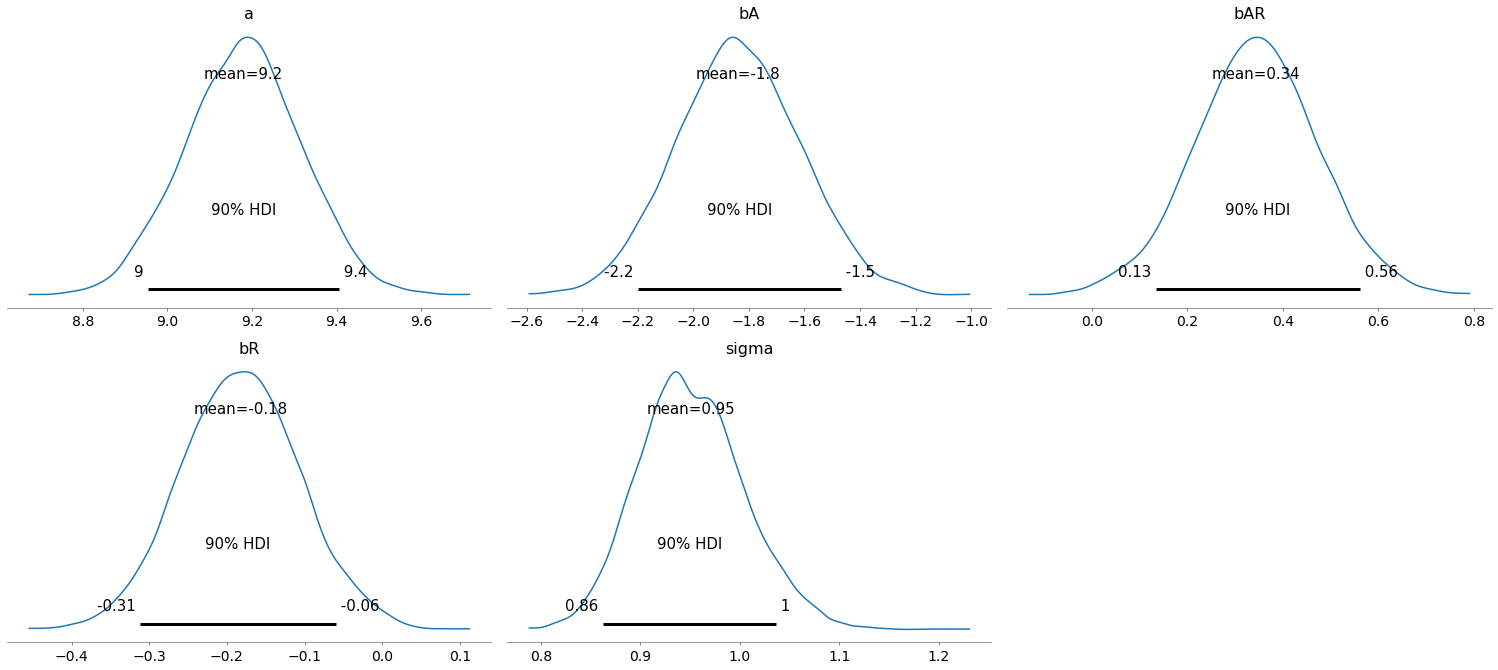

In [95]:
arviz.plot_posterior(inferenceData, var_names=['a', 'bA', 'bAR', 'bR', 'sigma'], hdi_prob=.9);